<a href="https://colab.research.google.com/github/gizemkaratas/CLTV_For_FLO/blob/main/CLTV_FLO.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [43]:
!pip install lifetimes
import datetime as dt
import pandas as pd
import matplotlib.pyplot as plt
from lifetimes import BetaGeoFitter
from lifetimes import GammaGammaFitter
from lifetimes.plotting import plot_period_transactions

pd.set_option('display.max_columns', None)
pd.set_option('display.width', 500)
pd.set_option('display.float_format', lambda x: '%.4f' % x)
from sklearn.preprocessing import MinMaxScaler

In [44]:
df=pd.read_csv("flo_data_20k.csv")

master_id Eşsiz müşteri numarası
order_channel Alışveriş yapılan platforma ait hangi kanalın kullanıldığı (Android, ios, Desktop, Mobile)
last_order_channel En son alışverişin yapıldığı kanal
first_order_date Müşterinin yaptığı ilk alışveriş tarihi
last_order_date Müşterinin yaptığı son alışveriş tarihi
last_order_date_online Müşterinin online platformda yaptığı son alışveriş tarihi
last_order_date_offline Müşterinin offline platformda yaptığı son alışveriş tarihi
order_num_total_ever_online Müşterinin online platformda yaptığı toplam alışveriş sayısı
order_num_total_ever_offline Müşterinin offline'da yaptığı toplam alışveriş sayısı
customer_value_total_ever_offline Müşterinin offline alışverişlerinde ödediği toplam ücret
customer_value_total_ever_online Müşterinin online alışverişlerinde ödediği toplam ücret
interested_in_categories_12 Müşterinin son 12 ayda alışveriş yaptığı kategorilerin listesi
store_type 3 farklı companyi ifade eder. A company'sinden alışveriş yapan kişi B'dende yaptı ise A,B şeklinde yazılmıştır.


In [45]:
df.head()

,master_id,order_channel,last_order_channel,first_order_date,last_order_date,last_order_date_online,last_order_date_offline,order_num_total_ever_online,order_num_total_ever_offline,customer_value_total_ever_offline,customer_value_total_ever_online,interested_in_categories_12
0,cc294636-19f0-11eb-8d74-000d3a38a36f,Android App,Offline,2020-10-30,2021-02-26,2021-02-21,2021-02-26,4.0000,1.0000,139.9900,799.3800,[KADIN]
1,f431bd5a-ab7b-11e9-a2fc-000d3a38a36f,Android App,Mobile,2017-02-08,2021-02-16,2021-02-16,2020-01-10,19.0000,2.0000,159.9700,1853.5800,"[ERKEK, COCUK, KADIN, AKTIFSPOR]"
2,69b69676-1a40-11ea-941b-000d3a38a36f,Android App,Android App,2019-11-27,2020-11-27,2020-11-27,2019-12-01,3.0000,2.0000,189.9700,395.3500,"[ERKEK, KADIN]"
3,1854e56c-491f-11eb-806e-000d3a38a36f,Android App,Android App,2021-01-06,2021-01-17,2021-01-17,2021-01-06,1.0000,1.0000,39.9900,81.9800,"[AKTIFCOCUK, COCUK]"
4,d6ea1074-f1f5-11e9-9346-000d3a38a36f,Desktop,Desktop,2019-08-03,2021-03-07,2021-03-07,2019-08-03,1.0000,1.0000,49.9900,159.9900,[AKTIFSPOR]


In [46]:
df.shape

(19945, 12)

In [47]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
order_num_total_ever_online,19945.0000,3.1109,4.2256,1.0000,1.0000,2.0000,4.0000,200.0000
order_num_total_ever_offline,19945.0000,1.9139,2.0629,1.0000,1.0000,1.0000,2.0000,109.0000
customer_value_total_ever_offline,19945.0000,253.9226,301.5329,10.0000,99.9900,179.9800,319.9700,18119.1400
customer_value_total_ever_online,19945.0000,497.3217,832.6019,12.9900,149.9800,286.4600,578.4400,45220.1300


In [48]:
df.isnull().sum()

,0
master_id,0
order_channel,0
last_order_channel,0
first_order_date,0
last_order_date,0
last_order_date_online,0
last_order_date_offline,0
order_num_total_ever_online,0
order_num_total_ever_offline,0
customer_value_total_ever_offline,0


In [49]:
#Aykırı değerleri baskılayalım
def outlier_thresholds(dataframe, variable):
    quartile1 = dataframe[variable].quantile(0.01)
    quartile3 = dataframe[variable].quantile(0.99)
    interquantile_range = quartile3 - quartile1
    up_limit = quartile3 + 1.5 * interquantile_range
    low_limit = quartile1 - 1.5 * interquantile_range
    return low_limit, up_limit


def replace_with_thresholds(dataframe, variable):
    low_limit, up_limit = outlier_thresholds(dataframe, variable)
    dataframe.loc[(dataframe[variable] > up_limit), variable] = up_limit
    dataframe.loc[(dataframe[variable] < low_limit), variable] = low_limit

In [50]:
replace_with_thresholds(df, "order_num_total_ever_online")
replace_with_thresholds(df, "order_num_total_ever_offline")
replace_with_thresholds(df, "customer_value_total_ever_offline")
replace_with_thresholds(df, "customer_value_total_ever_online")

In [51]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
order_num_total_ever_online,19945.0000,3.0923,3.8137,1.0000,1.0000,2.0000,4.0000,48.5000
order_num_total_ever_offline,19945.0000,1.8862,1.4347,1.0000,1.0000,1.0000,2.0000,16.0000
customer_value_total_ever_offline,19945.0000,251.9212,251.0226,10.0000,99.9900,179.9800,319.9700,3019.8820
customer_value_total_ever_online,19945.0000,489.7054,632.6064,12.9900,149.9800,286.4600,578.4400,7799.5410


In [52]:
# prompt:  Her bir müşterinin toplam
# alışveriş sayısı ve harcaması için yeni değişkenler oluşturalım

df["order_num_total"] = df["order_num_total_ever_online"] + df["order_num_total_ever_offline"]
df["customer_value_total"] = df["customer_value_total_ever_offline"] + df["customer_value_total_ever_online"]

df.head()


,master_id,order_channel,last_order_channel,first_order_date,last_order_date,last_order_date_online,last_order_date_offline,order_num_total_ever_online,order_num_total_ever_offline,customer_value_total_ever_offline,customer_value_total_ever_online,interested_in_categories_12,order_num_total,customer_value_total
0,cc294636-19f0-11eb-8d74-000d3a38a36f,Android App,Offline,2020-10-30,2021-02-26,2021-02-21,2021-02-26,4.0000,1.0000,139.9900,799.3800,[KADIN],5.0000,939.3700
1,f431bd5a-ab7b-11e9-a2fc-000d3a38a36f,Android App,Mobile,2017-02-08,2021-02-16,2021-02-16,2020-01-10,19.0000,2.0000,159.9700,1853.5800,"[ERKEK, COCUK, KADIN, AKTIFSPOR]",21.0000,2013.5500
2,69b69676-1a40-11ea-941b-000d3a38a36f,Android App,Android App,2019-11-27,2020-11-27,2020-11-27,2019-12-01,3.0000,2.0000,189.9700,395.3500,"[ERKEK, KADIN]",5.0000,585.3200
3,1854e56c-491f-11eb-806e-000d3a38a36f,Android App,Android App,2021-01-06,2021-01-17,2021-01-17,2021-01-06,1.0000,1.0000,39.9900,81.9800,"[AKTIFCOCUK, COCUK]",2.0000,121.9700
4,d6ea1074-f1f5-11e9-9346-000d3a38a36f,Desktop,Desktop,2019-08-03,2021-03-07,2021-03-07,2019-08-03,1.0000,1.0000,49.9900,159.9900,[AKTIFSPOR],2.0000,209.9800


In [53]:
df.dtypes

,0
master_id,object
order_channel,object
last_order_channel,object
first_order_date,object
last_order_date,object
last_order_date_online,object
last_order_date_offline,object
order_num_total_ever_online,float64
order_num_total_ever_offline,float64
customer_value_total_ever_offline,float64


In [54]:
# prompt: tarih değişkenlerinin tipini değiştirelim date yapalım

import pandas as pd
date_columns = df.columns[df.columns.str.contains("date")]
df[date_columns] = df[date_columns].apply(pd.to_datetime)


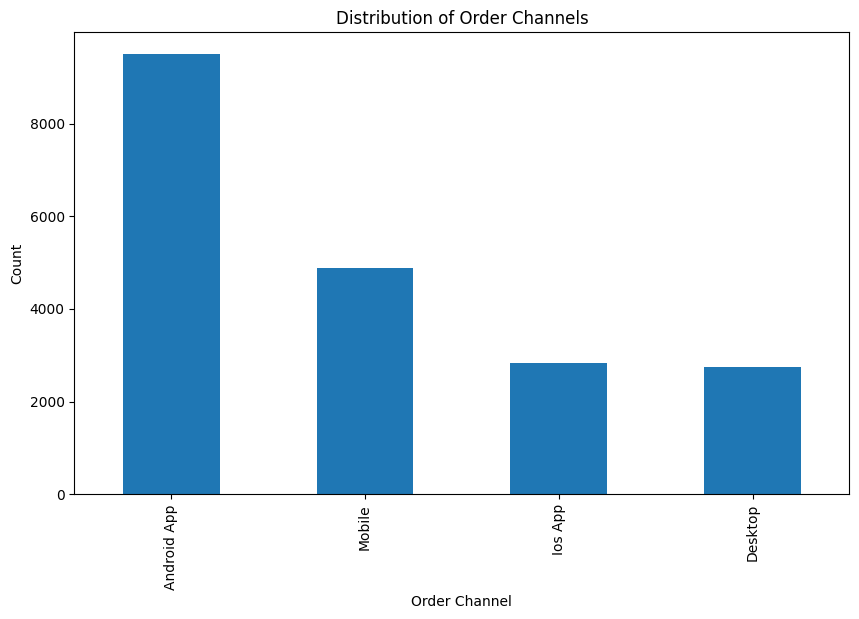

In [55]:
# prompt: order chanelı grafikleştir

import matplotlib.pyplot as plt
df["order_channel"].value_counts().plot(kind='bar', figsize=(10, 6))
plt.xlabel('Order Channel')
plt.ylabel('Count')
plt.title('Distribution of Order Channels')
plt.show()


category
 AKTIFSPOR]    17.3006
[ERKEK         10.8174
[AKTIFSPOR]    10.4407
[AKTIFCOCUK     8.3127
[KADIN]         6.5043
[]              6.4350
 KADIN]         6.3958
[ERKEK]         5.9467
 KADIN          5.9407
 COCUK          4.9250
[KADIN          4.0750
[COCUK          3.0171
 ERKEK          2.7970
[COCUK]         2.5197
 COCUK]         2.0676
[AKTIFCOCUK]    2.0465
 ERKEK]         0.4581
Name: count, dtype: float64


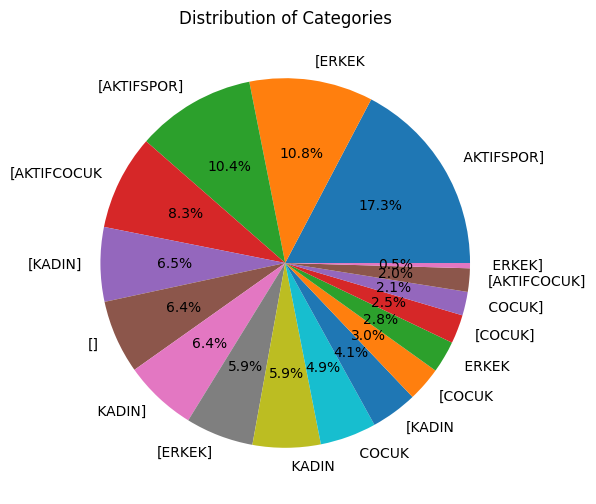

In [56]:
# prompt: interested_in_categories_12 grafikleştir ve hesapla yüzdelikleri

import matplotlib.pyplot as plt
# interested_in_categories_12 sütununu virgülle ayrılmış kategorilere ayırın
categories = df['interested_in_categories_12'].str.split(',', expand=True).stack().reset_index(level=0).set_index('level_0').rename(columns={0:'category'})

# Her kategorinin sayısını hesaplayın
category_counts = categories['category'].value_counts()

# Yüzdelikleri hesaplayın
category_percentages = category_counts / category_counts.sum() * 100

# Sonuçları yazdırın
print(category_percentages)

# Pasta grafiği oluşturun
plt.figure(figsize=(10, 6))
category_percentages.plot(kind='pie', autopct='%1.1f%%')
plt.title('Distribution of Categories')
plt.ylabel('')
plt.show()


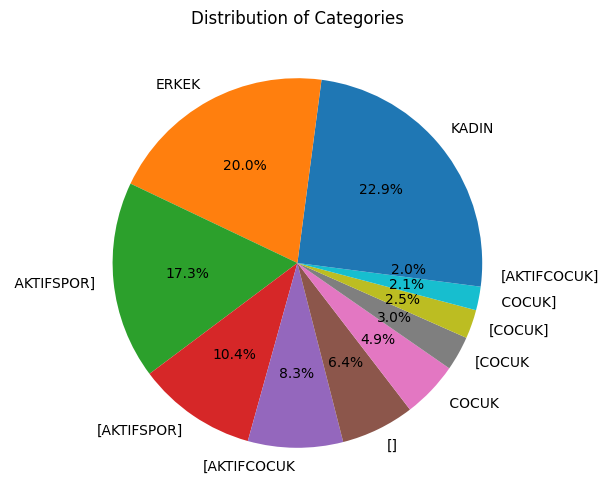

In [58]:
import pandas as pd
import matplotlib.pyplot as plt

# KADIN içeren kategorileri birleştir
kadın_categories = category_percentages[category_percentages.index.str.contains("KADIN")].sum()

# ERKEK içeren kategorileri birleştir
erkek_categories = category_percentages[category_percentages.index.str.contains("ERKEK")].sum()

# Diğer kategorileri filtrele
diger_categories = category_percentages[~category_percentages.index.str.contains("KADIN|ERKEK")]

# Yeni bir seri oluştur
new_categories = pd.concat([pd.Series({"KADIN": kadın_categories, "ERKEK": erkek_categories}), diger_categories])

# Pasta grafiği oluştur
plt.figure(figsize=(10, 6))
new_categories.plot(kind='pie', autopct='%1.1f%%')
plt.title('Distribution of Categories')
plt.ylabel('')
plt.show()



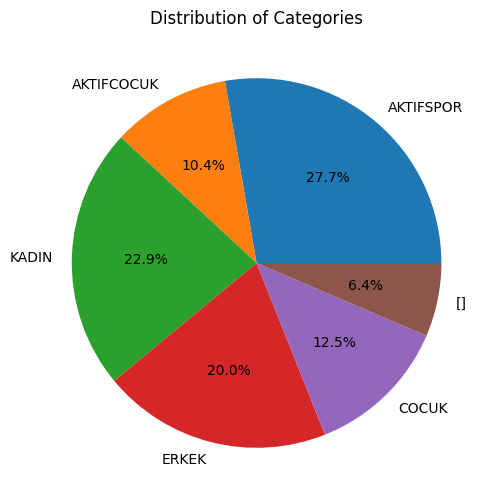

In [61]:
# prompt: içinde AKTIFSPOR geçen değişkenleri birleştir, içinde AKTIFCOCUK geçen değişkenleri birleştir, içinde KADIN geçen değişkenleri birleştir, içinde ERKEK geçen değişkenleri birleştir ve AKTIF geçmeyen ama COCUK geçen değişkenleri de birleştir

import pandas as pd
import matplotlib.pyplot as plt
# İçinde AKTIFSPOR geçen değişkenleri birleştir
aktifspor_categories = category_percentages[category_percentages.index.str.contains("AKTIFSPOR")].sum()

# İçinde AKTIFCOCUK geçen değişkenleri birleştir
aktifcocuk_categories = category_percentages[category_percentages.index.str.contains("AKTIFCOCUK")].sum()

# İçinde KADIN geçen değişkenleri birleştir
kadın_categories = category_percentages[category_percentages.index.str.contains("KADIN")].sum()

# İçinde ERKEK geçen değişkenleri birleştir
erkek_categories = category_percentages[category_percentages.index.str.contains("ERKEK")].sum()

# AKTIF geçmeyen ama COCUK geçen değişkenleri birleştir
cocuk_categories = category_percentages[(~category_percentages.index.str.contains("AKTIF")) & (category_percentages.index.str.contains("COCUK"))].sum()

# Diğer kategorileri filtrele
diger_categories = category_percentages[~category_percentages.index.str.contains("AKTIFSPOR|AKTIFCOCUK|KADIN|ERKEK|COCUK")]

# Yeni bir seri oluştur
new_categories = pd.concat([pd.Series({"AKTIFSPOR": aktifspor_categories,
                                      "AKTIFCOCUK": aktifcocuk_categories,
                                      "KADIN": kadın_categories,
                                      "ERKEK": erkek_categories,
                                      "COCUK": cocuk_categories}),
                            diger_categories])

# Pasta grafiği oluştur
plt.figure(figsize=(10, 6))
new_categories.plot(kind='pie', autopct='%1.1f%%')
plt.title('Distribution of Categories')
plt.ylabel('')
plt.show()


In [62]:
# prompt: order chanelı hesapla ve yüzdelikte hesapla

order_channel_counts = df["order_channel"].value_counts()
order_channel_percentages = order_channel_counts / order_channel_counts.sum() * 100

print(order_channel_counts)
print(order_channel_percentages)


order_channel
Android App    9495
Mobile         4882
Ios App        2833
Desktop        2735
Name: count, dtype: int64
order_channel
Android App   47.6059
Mobile        24.4773
Ios App       14.2041
Desktop       13.7127
Name: count, dtype: float64


In [63]:
# prompt: Purchase Frequency  Daily
# Weekly
# Monthly
# Quarterly hesapla yüzdelikleri ortalamaları ver

# Günlük satın alma sıklığı
daily_purchases = df.groupby(df['first_order_date'].dt.date)['master_id'].nunique()
daily_purchase_percentage = (daily_purchases / df['master_id'].nunique()) * 100
print("Daily Purchase Frequency:\n", daily_purchase_percentage)
print("Average Daily Purchase Percentage:", daily_purchase_percentage.mean())

# Haftalık satın alma sıklığı
weekly_purchases = df.groupby(df['first_order_date'].dt.isocalendar().week)['master_id'].nunique()
weekly_purchase_percentage = (weekly_purchases / df['master_id'].nunique()) * 100
print("\nWeekly Purchase Frequency:\n", weekly_purchase_percentage)
print("Average Weekly Purchase Percentage:", weekly_purchase_percentage.mean())

# Aylık satın alma sıklığı
monthly_purchases = df.groupby(df['first_order_date'].dt.to_period('M'))['master_id'].nunique()
monthly_purchase_percentage = (monthly_purchases / df['master_id'].nunique()) * 100
print("\nMonthly Purchase Frequency:\n", monthly_purchase_percentage)
print("Average Monthly Purchase Percentage:", monthly_purchase_percentage.mean())

# Üç aylık satın alma sıklığı
quarterly_purchases = df.groupby(df['first_order_date'].dt.to_period('Q'))['master_id'].nunique()
quarterly_purchase_percentage = (quarterly_purchases / df['master_id'].nunique()) * 100
print("\nQuarterly Purchase Frequency:\n", quarterly_purchase_percentage)
print("Average Quarterly Purchase Percentage:", quarterly_purchase_percentage.mean())


Daily Purchase Frequency:
 first_order_date
2013-01-14   0.0050
2013-01-20   0.0050
2013-01-27   0.0100
2013-01-28   0.0100
2013-01-30   0.0050
              ...  
2021-05-20   0.0100
2021-05-22   0.0050
2021-05-24   0.0100
2021-05-26   0.0100
2021-05-27   0.0050
Name: master_id, Length: 2465, dtype: float64
Average Daily Purchase Percentage: 0.04056795131845842

Weekly Purchase Frequency:
 week
1    1.4690
2    1.6546
3    1.6696
4    1.6345
5    1.7999
6    1.6696
7    3.0634
8    3.2189
9    2.2612
10   2.6322
11   2.6974
12   2.1710
13   2.1359
14   2.1158
15   1.9052
16   2.1158
17   1.5442
18   1.3938
19   1.5092
20   1.6345
21   1.1833
22   0.9727
23   1.0780
24   1.0278
25   1.3888
26   1.7448
27   1.8752
28   2.0958
29   2.0757
30   1.9253
31   2.1760
32   1.6596
33   1.2986
34   1.6495
35   2.0155
36   2.1409
37   2.3063
38   1.9855
39   1.6896
40   1.6746
41   2.0105
42   2.3314
43   2.1359
44   2.1810
45   2.3063
46   2.2462
47   2.6172
48   2.5219
49   1.8250
50   1.8852
5

In [64]:
# prompt: offline ve onlinedan yapılan alışveriş sıklığını aylık bazlı kıyaslayalım

# Aylık online alışveriş sıklığı
monthly_online_purchases = df.groupby(df['last_order_date_online'].dt.to_period('M'))['master_id'].nunique()
monthly_online_purchase_percentage = (monthly_online_purchases / df['master_id'].nunique()) * 100
print("\nMonthly Online Purchase Frequency:\n", monthly_online_purchase_percentage)
print("Average Monthly Online Purchase Percentage:", monthly_online_purchase_percentage.mean())

# Aylık offline alışveriş sıklığı
monthly_offline_purchases = df.groupby(df['last_order_date_offline'].dt.to_period('M'))['master_id'].nunique()
monthly_offline_purchase_percentage = (monthly_offline_purchases / df['master_id'].nunique()) * 100
print("\nMonthly Offline Purchase Frequency:\n", monthly_offline_purchase_percentage)
print("Average Monthly Offline Purchase Percentage:", monthly_offline_purchase_percentage.mean())



Monthly Online Purchase Frequency:
 last_order_date_online
2014-02    0.0050
2014-03    0.0552
2014-04    0.0501
2014-05    0.0351
2014-06    0.0351
            ...  
2021-01    7.2299
2021-02    6.7185
2021-03    6.5179
2021-04    9.1853
2021-05   16.8864
Freq: M, Name: master_id, Length: 88, dtype: float64
Average Monthly Online Purchase Percentage: 1.1363636363636365

Monthly Offline Purchase Frequency:
 last_order_date_offline
2019-01   0.0401
2019-02   1.8701
2019-03   2.4116
2019-04   2.0155
2019-05   0.4964
2019-06   0.7972
2019-07   3.0785
2019-08   3.9659
2019-09   4.7932
2019-10   4.8183
2019-11   5.7257
2019-12   5.0740
2020-01   5.1191
2020-02   4.9737
2020-03   2.5169
2020-05   0.4362
2020-06   3.0283
2020-07   7.1246
2020-08   3.6751
2020-09   3.0534
2020-10   3.0534
2020-11   4.5625
2020-12   3.0885
2021-01   4.0612
2021-02   4.9336
2021-03   7.1196
2021-04   4.7882
2021-05   3.3793
Freq: M, Name: master_id, dtype: float64
Average Monthly Offline Purchase Percentage: 3.

In [65]:
# prompt:  offline ve onlinedan yapılan alışveriş sıklığını Weekly Offline
# Weekly Online
# Monthly Offline
# Monthly Online
# Quartly Offline
# Quartly Online
# Yearly Offline
# Yearly Online ort kıyasla

# Haftalık online alışveriş sıklığı
weekly_online_purchases = df.groupby(df['last_order_date_online'].dt.isocalendar().week)['master_id'].nunique()
weekly_online_purchase_percentage = (weekly_online_purchases / df['master_id'].nunique()) * 100
print("\nWeekly Online Purchase Frequency:\n", weekly_online_purchase_percentage)
print("Average Weekly Online Purchase Percentage:", weekly_online_purchase_percentage.mean())

# Haftalık offline alışveriş sıklığı
weekly_offline_purchases = df.groupby(df['last_order_date_offline'].dt.isocalendar().week)['master_id'].nunique()
weekly_offline_purchase_percentage = (weekly_offline_purchases / df['master_id'].nunique()) * 100
print("\nWeekly Offline Purchase Frequency:\n", weekly_offline_purchase_percentage)
print("Average Weekly Offline Purchase Percentage:", weekly_offline_purchase_percentage.mean())

# Üç aylık online alışveriş sıklığı
quarterly_online_purchases = df.groupby(df['last_order_date_online'].dt.to_period('Q'))['master_id'].nunique()
quarterly_online_purchase_percentage = (quarterly_online_purchases / df['master_id'].nunique()) * 100
print("\nQuarterly Online Purchase Frequency:\n", quarterly_online_purchase_percentage)
print("Average Quarterly Online Purchase Percentage:", quarterly_online_purchase_percentage.mean())

# Üç aylık offline alışveriş sıklığı
quarterly_offline_purchases = df.groupby(df['last_order_date_offline'].dt.to_period('Q'))['master_id'].nunique()
quarterly_offline_purchase_percentage = (quarterly_offline_purchases / df['master_id'].nunique()) * 100
print("\nQuarterly Offline Purchase Frequency:\n", quarterly_offline_purchase_percentage)
print("Average Quarterly Offline Purchase Percentage:", quarterly_offline_purchase_percentage.mean())

# Yıllık online alışveriş sıklığı
yearly_online_purchases = df.groupby(df['last_order_date_online'].dt.to_period('Y'))['master_id'].nunique()
yearly_online_purchase_percentage = (yearly_online_purchases / df['master_id'].nunique()) * 100
print("\nYearly Online Purchase Frequency:\n", yearly_online_purchase_percentage)
print("Average Yearly Online Purchase Percentage:", yearly_online_purchase_percentage.mean())

# Yıllık offline alışveriş sıklığı
yearly_offline_purchases = df.groupby(df['last_order_date_offline'].dt.to_period('Y'))['master_id'].nunique()
yearly_offline_purchase_percentage = (yearly_offline_purchases / df['master_id'].nunique()) * 100
print("\nYearly Offline Purchase Frequency:\n", yearly_offline_purchase_percentage)
print("Average Yearly Offline Purchase Percentage:", yearly_offline_purchase_percentage.mean())



Weekly Online Purchase Frequency:
 week
1    1.7247
2    2.5370
3    1.9253
4    1.5041
5    1.6395
6    2.0958
7    2.4517
8    1.7298
9    1.7047
10   1.9654
11   2.3013
12   1.6896
13   2.3063
14   2.2763
15   2.9230
16   3.2038
17   4.0913
18   6.2321
19   4.7882
20   5.1592
21   4.2818
22   0.8975
23   1.3437
24   1.3788
25   1.6696
26   1.2484
27   1.0730
28   0.8072
29   0.8925
30   0.7671
31   0.6117
32   0.5014
33   0.5766
34   0.5766
35   0.6117
36   0.6618
37   0.9877
38   1.0930
39   0.9626
40   1.2033
41   1.8200
42   1.2735
43   1.0078
44   0.9276
45   1.3738
46   2.8027
47   1.6696
48   4.7029
49   1.3838
50   1.6144
51   1.9253
52   1.9303
53   1.1732
Name: master_id, dtype: float64
Average Weekly Online Purchase Percentage: 1.8867924528301887

Weekly Offline Purchase Frequency:
 week
1    1.8451
2    1.9955
3    2.4568
4    2.4016
5    2.6322
6    2.8027
7    3.0083
8    3.0233
9    3.3141
10   3.4395
11   2.9080
12   2.2412
13   1.7799
14   1.9604
15   1.5844
16   1.

In [66]:
# prompt: son alışveriş yapılan günü bulalım

df["last_order_date"].max()


Timestamp('2021-05-30 00:00:00')

In [67]:
today_date = dt.datetime(2021, 5 ,28) #analiz tarihi

In [68]:
def create_cltv_df(dataframe):
    # Data Preperation
    columns = ["order_num_total_ever_online", "order_num_total_ever_offline", "customer_value_total_ever_offline","customer_value_total_ever_online"]
    for col in columns:
        replace_with_thresholds(dataframe, col)

    dataframe["order_num_total"] = dataframe["order_num_total_ever_online"] + dataframe["order_num_total_ever_offline"]
    dataframe["customer_value_total"] = dataframe["customer_value_total_ever_offline"] + dataframe["customer_value_total_ever_online"]
    dataframe = dataframe[~(dataframe["customer_value_total"] == 0) | (dataframe["order_num_total"] == 0)]
    date_columns = dataframe.columns[dataframe.columns.str.contains("date")]
    dataframe[date_columns] = dataframe[date_columns].apply(pd.to_datetime)

    # Creation of CLTV data structure
    analysis_date = dt.datetime(2021, 6, 1)
    cltv_df = pd.DataFrame()
    cltv_df["customer_id"] = dataframe["master_id"]
    cltv_df["recency_cltv_weekly"] = (dataframe["last_order_date"] - dataframe["first_order_date"]).dt.days / 7
    cltv_df["T_weekly"] = (analysis_date - dataframe["first_order_date"]).dt.days / 7
    cltv_df["frequency"] = dataframe["order_num_total"].round().astype(int)
    cltv_df["monetary_cltv_avg"] = dataframe["customer_value_total"] / dataframe["order_num_total"]
    cltv_df = cltv_df[(cltv_df['frequency'] > 1)]

    # Establishment of BG-NBD Model
    bgf = BetaGeoFitter(penalizer_coef=0.001)
    bgf.fit(cltv_df['frequency'], cltv_df['recency_cltv_weekly'], cltv_df['T_weekly'])
    cltv_df["exp_sales_3_month"] = bgf.predict(4 * 3, cltv_df['frequency'], cltv_df['recency_cltv_weekly'], cltv_df['T_weekly'])
    cltv_df["exp_sales_6_month"] = bgf.predict(4 * 6, cltv_df['frequency'], cltv_df['recency_cltv_weekly'], cltv_df['T_weekly'])

    # Establishing the Gamma-Gamma Model
    ggf = GammaGammaFitter(penalizer_coef=0.01)
    ggf.fit(cltv_df['frequency'], cltv_df['monetary_cltv_avg'])
    cltv_df["exp_average_value"] = ggf.conditional_expected_average_profit(cltv_df['frequency'], cltv_df['monetary_cltv_avg'])

    # CLTV Forecasting
    cltv = ggf.customer_lifetime_value(bgf, cltv_df['frequency'], cltv_df['recency_cltv_weekly'], cltv_df['T_weekly'], cltv_df['monetary_cltv_avg'], time=6, freq="W", discount_rate=0.01)
    cltv_df["cltv"] = cltv

    # CLTV Segmentation
    cltv_df["cltv_segment"] = pd.qcut(cltv_df["cltv"], 4, labels=["D", "C", "B", "A"])

    return cltv_df



In [69]:
cltv_df = create_cltv_df(df)

In [70]:
cltv_df.head()

,customer_id,recency_cltv_weekly,T_weekly,frequency,monetary_cltv_avg,exp_sales_3_month,exp_sales_6_month,exp_average_value,cltv,cltv_segment
0,cc294636-19f0-11eb-8d74-000d3a38a36f,17.0000,30.5714,5,187.8740,0.9740,1.9481,193.6327,395.7800,A
1,f431bd5a-ab7b-11e9-a2fc-000d3a38a36f,209.8571,224.8571,21,95.8833,0.9832,1.9664,96.6650,199.4391,B
2,69b69676-1a40-11ea-941b-000d3a38a36f,52.2857,78.8571,5,117.0640,0.6706,1.3412,120.9676,170.2321,B
3,1854e56c-491f-11eb-806e-000d3a38a36f,1.5714,20.8571,2,60.9850,0.7005,1.4009,67.3201,98.9536,D
4,d6ea1074-f1f5-11e9-9346-000d3a38a36f,83.1429,95.4286,2,104.9900,0.3960,0.7921,114.3251,95.0090,D


In [71]:
# 6 ay içinde en çok alışveriş yapacak 10 müşteri

cltv_df.sort_values("exp_sales_6_month",ascending=False)[:10]


,customer_id,recency_cltv_weekly,T_weekly,frequency,monetary_cltv_avg,exp_sales_3_month,exp_sales_6_month,exp_average_value,cltv,cltv_segment
7330,a4d534a2-5b1b-11eb-8dbd-000d3a38a36f,62.7143,67.2857,52,164.6328,4.6569,9.3137,165.1165,1613.5441,A
15611,4a7e875e-e6ce-11ea-8f44-000d3a38a36f,39.7143,40.0000,29,165.2976,3.3746,6.7491,166.1696,1176.7055,A
8328,1902bf80-0035-11eb-8341-000d3a38a36f,28.8571,33.2857,25,97.4396,3.1430,6.2860,98.1036,647.0327,A
19538,55d54d9e-8ac7-11ea-8ec0-000d3a38a36f,52.5714,58.7143,31,228.5300,3.0843,6.1685,229.6069,1486.0483,A
14373,f00ad516-c4f4-11ea-98f7-000d3a38a36f,38.0000,46.4286,27,141.3548,3.0018,6.0036,142.1780,895.5934,A
10489,7af5cd16-b100-11e9-9757-000d3a38a36f,103.1429,111.8571,43,157.1126,2.9784,5.9567,157.6754,985.4644,A
4315,d5ef8058-a5c6-11e9-a2fc-000d3a38a36f,133.1429,147.1429,50,160.2026,2.8839,5.7678,160.6944,972.4772,A
6756,27310582-6362-11ea-a6dc-000d3a38a36f,62.7143,64.1429,29,168.8810,2.7938,5.5877,169.7689,995.3058,A
6666,53fe00d4-7b7a-11eb-960b-000d3a38a36f,9.7143,13.0000,17,259.8653,2.7813,5.5626,262.0729,1529.5776,A
10536,e143b6fa-d6f8-11e9-93bc-000d3a38a36f,104.5714,113.4286,40,176.2000,2.7638,5.5276,176.8663,1025.7645,A


In [72]:
#  Cltv değeri en yüksek 20 kişi:

cltv_df.sort_values("cltv",ascending=False)[:20]


,customer_id,recency_cltv_weekly,T_weekly,frequency,monetary_cltv_avg,exp_sales_3_month,exp_sales_6_month,exp_average_value,cltv,cltv_segment
9055,47a642fe-975b-11eb-8c2a-000d3a38a36f,2.8571,7.8571,4,1401.7705,1.0946,2.1891,1449.0298,3328.2592,A
13880,7137a5c0-7aad-11ea-8f20-000d3a38a36f,6.1429,13.1429,11,758.0437,1.9705,3.9410,767.3184,3172.8829,A
17323,f59053e2-a503-11e9-a2fc-000d3a38a36f,51.7143,101.0000,7,1106.4671,0.7223,1.4445,1127.6115,1709.0637,A
12438,625f40a2-5bd2-11ea-98b0-000d3a38a36f,74.2857,74.5714,16,501.8451,1.5655,3.1310,506.1377,1662.7075,A
8868,9ce6e520-89b0-11ea-a6e7-000d3a38a36f,3.4286,34.4286,8,601.2262,1.2656,2.5313,611.4926,1624.0385,A
7330,a4d534a2-5b1b-11eb-8dbd-000d3a38a36f,62.7143,67.2857,52,164.6328,4.6569,9.3137,165.1165,1613.5441,A
6402,851de3b4-8f0c-11eb-8cb8-000d3a38a36f,8.2857,9.4286,2,862.6900,0.7940,1.5880,923.6797,1539.0341,A
6666,53fe00d4-7b7a-11eb-960b-000d3a38a36f,9.7143,13.0000,17,259.8653,2.7813,5.5626,262.0729,1529.5776,A
19538,55d54d9e-8ac7-11ea-8ec0-000d3a38a36f,52.5714,58.7143,31,228.5300,3.0843,6.1685,229.6069,1486.0483,A
14858,031b2954-6d28-11eb-99c4-000d3a38a36f,14.8571,15.5714,3,743.5867,0.8717,1.7433,778.0503,1423.1737,A


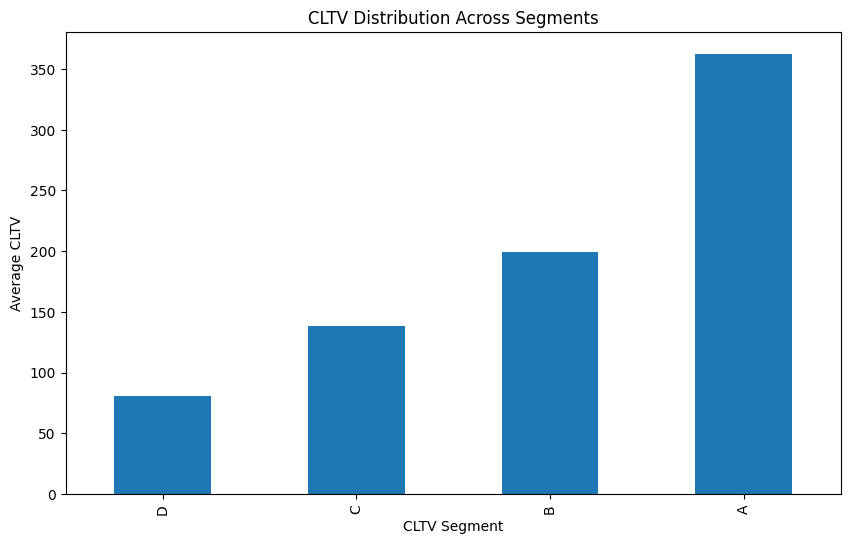

In [73]:
import matplotlib.pyplot as plt
# CLTV segmentlerine göre dağılımı görselleştirme
cltv_df.groupby('cltv_segment')['cltv'].mean().plot(kind='bar', figsize=(10, 6))
plt.xlabel('CLTV Segment')
plt.ylabel('Average CLTV')
plt.title('CLTV Distribution Across Segments')
plt.show()


In [74]:
# Segmentlere göre ortalama CLV değerlerini hesaplayın
segment_clv = cltv_df.groupby('cltv_segment')['cltv'].mean()

# Sonuçları yazdırın
print(segment_clv)


cltv_segment
D    80.3392
C   138.3130
B   199.5377
A   362.3402
Name: cltv, dtype: float64
